# Reservoirs in Catalunya
***

**_Autor:_** Chus Casado Rodríguez<br>
**_Fecha:_** 15-03-2024<br>

**Introduction:**<br>
This code preprocesses the reservoir time series downloaded from [Agència Catalana de l'Aigua](https://analisi.transparenciacatalunya.cat/es/Medi-Ambient/Xarxes-de-control-del-medi-consulta-de-l-aigua-i-e/wc95-u57z/about_data). The raw data includes reservoir attributes (coordinates, ID, name) and daily time series of reservoir storage, level and fraction filled. The results of the code are a CSV file with the reservoir attributes, and several CSV files (one for each reservoir) with the daily timeseries.

> **Note**. Later I've added manually data to the attributes table extracted from the CEDEX dataset.

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm.notebook import tqdm
import os
os.environ['USE_PYGEOS'] = '0'
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import requests

from utils.SNCZI import reservoir_attributes, dam_attributes

In [2]:
# path where the data is stored
path_datasets = Path('Z:/nahaUsers/casadje/datasets/')
path_aca = path_datasets / 'ACA'
path_cedex = path_datasets / 'CEDEX/processed/reservoirs/attributes/GIS/'

In [3]:
# path where attributes will be saved
path_attr = path_aca / 'processed' / 'reservoirs' / 'attributes'
path_GIS = path_attr / 'GIS'
path_GIS.mkdir(parents=True, exist_ok=True)

In [4]:
# paths where time series will be saved
path_ts = path_aca / 'processed' / 'reservoirs' / 'timeseries'
path_plot = path_ts / 'plots'
path_plot.mkdir(parents=True, exist_ok=True)

## ACA raw data

Here I load and prepocess the raw Excel files downloaded from the ACA website. The result are two objects: `timeseries` is a dictionary that contains the time series for each reservoir, `reservoirs_aca` is a DataFrame with the reservoir attributes.

In [5]:
# translation of attribute names
rename_columns = {'Data': 'date',
                  'Estació': 'station',
                  'Conca': 'basin',
                  'UTM X': 'X',
                  'UTM Y': 'Y',
                  'Variable': 'variable',
                  'Mitjana': 'average',
                  'Unitat Mesura': 'unit'}
# translation of reservoir variables
translate_variables = {'Nivell embassament': 'level',
                       'Percentatge volum embassat': 'filling',
                       'Volum embassament': 'volume',
                       'Volum embassat': 'volume'}

In [6]:
# time series will be saved in a dictionary and reservoir attributes in a pandas.DataFrame
timeseries = {}
reservoirs_aca = pd.DataFrame(columns=['name', 'basin', 'X', 'Y'])
reservoirs_aca.index.name = 'ID_ACA'

# read raw Excel files iteratively
path_in = path_aca / 'raw' / 'reservoirs'
for file in tqdm(list(path_in.glob('reservoirs_*.xlsx'))):

    # load time series
    df = pd.read_excel(file,
                       sheet_name="Quantitat d'aigua disponible",
                       skiprows=7,
                       usecols=range(1, 9),
                       engine='openpyxl')
    
    # rename columns
    df.rename(columns=rename_columns, inplace=True)
    
    # create index with the reservoir ID
    df['ID_ACA'] = [var.split('_')[0] for var in df.variable]
    df.set_index('ID_ACA', drop=True, inplace=True)

    # simplify station names
    rename_reservoirs = {name: ' '.join(name.upper().split('(')[0].split(' ')[2:]).strip() for name in df.station.unique()}
    df.station.replace(rename_reservoirs, inplace=True)
    
    # rename variable
    df.variable = [translate_variables[var.split('_')[-1].split('(')[0].strip()] for var in df.variable]

    df.tail()

    # iterate over stations
    for ID in df.index.unique():
        df_i = df.loc[ID].copy()
        
        # extract station attributes
        if ID not in reservoirs_aca.index:
            reservoirs_aca.loc[ID, ['name', 'basin', 'X', 'Y']] = df_i.iloc[0][['station', 'basin', 'X', 'Y']].values
        
        # extract timeseries
        df_pivot = df_i[['date', 'variable', 'average']].pivot(index='date',
                                                               columns='variable',
                                                               values='average')
        df_pivot.index = pd.to_datetime(df_pivot.index)
        df_pivot.rename_axis(None, axis=1, inplace=True)
        if ID in timeseries:
            timeseries[ID] = pd.concat((timeseries[ID], df_pivot), axis=0)
        else:
            timeseries[ID] = df_pivot

  0%|          | 0/8 [00:00<?, ?it/s]

C:\DEV\Anaconda3\envs\res\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
C:\DEV\Anaconda3\envs\res\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
C:\DEV\Anaconda3\envs\res\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
C:\DEV\Anaconda3\envs\res\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
C:\DEV\Anaconda3\envs\res\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook con

## Attributes

### Attributes from ACA

In [7]:
# sort 
reservoirs_aca.sort_index(inplace=True)

# convert into GeoDataFrame
reservoirs_aca[['X', 'Y']] = reservoirs_aca[['X', 'Y']].astype(int)
geometry = [Point(xy) for xy in zip(reservoirs_aca.X, reservoirs_aca.Y)]
reservoirs_aca = gpd.GeoDataFrame(reservoirs_aca, geometry=geometry, crs='epsg:25831')

# save lotitude and latitude
reservoirs_aca.to_crs('epsg:4326', inplace=True)
reservoirs_aca['lon'] = reservoirs_aca.geometry.x.round(6)
reservoirs_aca['lat'] = reservoirs_aca.geometry.y.round(6)

# # export
path_attr = path_aca / 'processed' / 'reservoirs' / 'attributes'
path_attr.mkdir(parents=True, exist_ok=True)
path_GIS = path_attr / 'GIS'
path_GIS.mkdir(parents=True, exist_ok=True)
# reservoirs_aca.to_file(path_attr / 'reservoirs_ACA_basic.shp')
# reservoirs_aca.loc[:, reservoirs_aca.columns != 'geometry'].to_csv(path_out / 'reservoirs_ACA_basic.csv', float_format='%f6')

### Attributes from SNCZI

I extract from the Spanish Inventory of Dams and Reservoirs (_Sistema Nacional de Cartografía de Zonas Inundables_) other reservoir and dam attributes (volume, normal level, river elevation...), to be later on added to `reservoirs_aca`.

In [8]:
# correspondence between IDs in ACA and the reservoir ID in the Spanish Invetory of Dams and Reservoirs
# I have derived this correspondence manually in QGIS!!!
map_ACA_SNCZI = {'E01': 351,
                 'E02': 1768,
                 'E06': 2109,
                 'E07': 2180,
                 'E08': 1628,
                 'E12': 1272,
                 'E13': 2044,
                 'E14': 234,
                 'E16': 930,
                 'E17': 971,
                 'E18': 692,
                 'E19': 1931,
                 'E20': None}

reservoirs_aca['SNCZI'] = [map_ACA_SNCZI[ID] for ID in reservoirs_aca.index]
reservoirs_aca.SNCZI = reservoirs_aca.SNCZI.astype('Int64')

#### Reservoir attributes

I will only download the reservoir reports from SNCZI. I will load this reports (`cedex_res`) only because they allow me to connect each reservoir with its main dam, but I will not add any attribute from them to `reservoirs_aca`.

In [9]:
# shapefile of reservoirs in the Spanish inventory
reservoirs_SNCZI = gpd.read_file(path_cedex / 'egis_embalse_geoetrs89.shp')
reservoirs_SNCZI['ID_EMBALSE'] = reservoirs_SNCZI['ID_EMBALSE'].astype(int)
reservoirs_SNCZI.set_index('ID_EMBALSE', drop=True, inplace=True)
reservoirs_SNCZI.sort_index(axis=0, inplace=True)
reservoirs_SNCZI.to_crs(epsg=25830, inplace=True)

print('SNCZI contains {0} reservoirs and {1} attributes'.format(*reservoirs_SNCZI.shape))
# reservoirs_SNCZI.head()

SNCZI contains 3170 reservoirs and 18 attributes


##### Download reports

In [10]:
path_reports_res = path_datasets / 'SNCZI' / 'reports' / 'reservoirs'
path_reports_res.mkdir(parents=True, exist_ok=True)
for ID in tqdm(reservoirs_aca.SNCZI):
    
    if pd.isna(ID):
        continue

    # output XML file
    filename = f'{path_reports_res}/{ID:04}.xml'
    if os.path.isfile(filename):
        continue
    
    # extract data from URL
    url = f'https://sig.mapama.gob.es/WebServices/clientews/snczi/Default.aspx?nombre=EGISPE_EMBALSE&claves=ID_EMBALSE&valores={ID}&op=ExpMultiple'
    
    with requests.get(url) as response:
        lines = [line.decode('utf-8') for line in response.iter_lines()]
    
    # export XML file
    with open(filename, 'w', encoding='utf-8') as file:
        file.writelines(line + '\n' for line in lines)

  0%|          | 0/13 [00:00<?, ?it/s]

##### Import reservoir attributes

In [11]:
cedex_res = pd.DataFrame(dtype='object')
for id_aca, id_snczi in tqdm(reservoirs_aca.SNCZI.items()):
    
    if pd.isna(id_snczi):
        continue
        
    file = f'{path_reports_res}/{id_snczi:04}.xml'
    try:
        cedex_res = pd.concat((cedex_res, reservoir_attributes(file, name=id_aca)), axis=1)
    except Exception as e:
        raise ValueError(f'File {file} could note be read: {str(e)}')

cedex_res = cedex_res.transpose()
cedex_res.index.name = 'ID_ACA'
cedex_res['Código del embalse'] = cedex_res['Código del embalse'].astype(int)

print('Imported from SNCZI {0} reservoirs and {1} attributes'.format(*cedex_res.shape))

0it [00:00, ?it/s]

Imported from SNCZI 12 reservoirs and 19 attributes


#### Dam attributes

In [12]:
# shapefile of dams in the Spanish inventory
dams_SNCZI = gpd.read_file(path_cedex / 'egis_presa_geoetrs89.shp')
cols_int = ['ID_INFRAES', 'CODIGO']
dams_SNCZI[cols_int] = dams_SNCZI[cols_int].astype(int)
dams_SNCZI.set_index('ID_INFRAES', drop=True, inplace=True)
dams_SNCZI.sort_index(inplace=True)
dams_SNCZI.to_crs(epsg=25830, inplace=True)

print('SNCZI contains {0} dams and {1} attributes'.format(*dams_SNCZI.shape))
# dams_SNCZI.head()

SNCZI contains 3208 dams and 23 attributes


##### Download reports

In [13]:
path_reports_dam = path_datasets / 'SNCZI' / 'reports' / 'dams'
path_reports_dam.mkdir(parents=True, exist_ok=True)
for id_aca in tqdm(reservoirs_aca.index):
    
    # find the ID of the dam
    try:
        code_infr = int(cedex_res.loc[id_aca, 'Código de infraestructura'])
    except Exception as e:
        print(f'Reservoir with ID_ACA {id_aca} does not have an infrastructure code')
        continue
    ID = dams_SNCZI.loc[dams_SNCZI.CODIGO == code_infr].index[0]

    # output XML file
    filename = f'{path_reports_dam}/{ID:04}.xml'
    if os.path.isfile(filename):
        continue
    
    # extract data from URL
    url = f'https://sig.mapama.gob.es/WebServices/clientews/snczi/Default.aspx?nombre=EGISPE_PRESA&claves=ID_INFRAESTRUCTURA&valores={ID}&op=Exportar'
    
    with requests.get(url) as response:
        lines = [line.decode('utf-8') for line in response.iter_lines()]
    
    # export XML file
    with open(filename, 'w', encoding='utf-8') as file:
        file.writelines(line + '\n' for line in lines)

  0%|          | 0/13 [00:00<?, ?it/s]

Reservoir with ID_ACA E20 does not have an infrastructure code


##### Import dam attributes

In [14]:
# read XML reports
cedex_dam = pd.DataFrame(dtype='object')
for id_aca in tqdm(reservoirs_aca.index):
    
    # find the ID of the dam
    try:
        code_infr = int(cedex_res.loc[id_aca, 'Código de infraestructura'])
    except:
        print(f'Reservoir with ID_ACA {id_aca} does not have an infrastructure code')
        continue
        
    ID = dams_SNCZI.loc[dams_SNCZI.CODIGO == code_infr].index[0]
    file = f'{path_reports_dam}/{ID:04}.xml'
    cedex_dam = pd.concat((cedex_dam, dam_attributes(file, name=id_aca)), axis=1)
cedex_dam = cedex_dam.transpose()
cedex_dam.index.name = 'ID_ACA'

print('Imported from SNCZI {0} dams and {1} attributes'.format(*cedex_dam.shape))

# rename columns
rename_cols = {'Nombre de la presa': 'dam_name',
               'Otro Nombre': 'other_name',
               'Fase vida presa': 'phase',
               'Titular de la presa': 'owner',
               'Proyectista': 'designer',
               'Categoría en función del riesgo potencial': 'category',
               'Aprobación de las normas de explotación': 'date_exploitation_plan',
               'Aprobación del plan de emergencia': 'date_emergency_plan',
               'Fecha de finalización de las obras': 'date_construction',
               'Río en el que se encuentra la presa': 'river', 
               'Municipio': 'town',
               'Cuenca hidrográfica': 'basin', 
               'Provincia': 'province', 
               'X-UTM30ETRS89': 'X', 
               'Y-UTM30ETRS89': 'Y',
               'Usuarios': 'users', 
               'Tipos': 'use', 
               'Superficie de la cuenca hidrográfica (km2)': 'catch_area',
               'Aportación media anual (hm3)': 'inflow', 
               'Precipitación media anual (mm)': 'precip',
               'Caudal punta avenida de proyecto (m3/s)': 'Q_design',
               'Superficie del embalse a NMN (ha)': 'A_MNL', # Nivel Máximo Normal => Maximum Normal Level
               'Capacidad a NMN (hm3)': 'V_MNL',
               'Cota del NMN (m)': 'Z_MNL', 
               'Tipo de presa': 'type', 
               'Cota coronación (m)': 'Z_crest',
               'Altura desde cimientos (m)': 'height', 
               'Longitud de coronación (m)': 'len_crest',
               'Cota cimentación (m)': 'Z_found', 
               'Cota del cauce en la presa (m)': 'Z_river',
               'Volumen del cuerpo presa (1000 m3)': 'dam_vol',
               'Número total de aliviaderos en la presa': 'no_spill', 
               'Regulación': 'regulation',
               'Capacidad a NAE (m3/s)': 'Qspill_EFL', # Nivel de Avenida Extrema => Extreme Flood Level
               'Número total de desagües en la presa': 'no_sluice',
               'Capacidad (m3/s)': 'Qsluice'}
cedex_dam.rename(columns=rename_cols, inplace=True)

# convert to date
for col in cedex_dam.columns[cedex_dam.columns.str.startswith('date')]:
    cedex_dam[col] = pd.to_datetime(cedex_dam[col], format='%d-%m-%Y', errors='coerce')
cedex_dam['year'] = cedex_dam.date_construction.dt.year

# convert reservoir area to km2
cedex_dam.A_MNL /= 100

# compute dicharge capacity of outlet structures
cedex_dam['Q_spill'] = cedex_dam.no_spill * cedex_dam.Qspill_EFL
cedex_dam['Q_sluice'] = cedex_dam.no_sluice * cedex_dam.Qsluice

  0%|          | 0/13 [00:00<?, ?it/s]

Reservoir with ID_ACA E20 does not have an infrastructure code
Imported from SNCZI 12 dams and 36 attributes


### Merge datasets

In [15]:
# add dam attributes to the table of reservoirs
dam_cols = ['year', 'catch_area', 'inflow', 'Q_design', 'Z_MNL', 'V_MNL', 'A_MNL', 'Z_crest', 'height', 'len_crest', 'Z_found', 'Z_river', 'Q_spill', 'Q_sluice']
reservoirs_aca = pd.concat((reservoirs_aca, cedex_dam[dam_cols]), axis=1)
# reservoirs_aca.index.name = 'ID_ACA'
reservoirs_aca.year = reservoirs_aca.year.astype('Int64')

In [18]:
# export
reservoirs_aca.to_file(path_GIS / 'reservoirs_ACA.shp')
reservoirs_aca.loc[:, reservoirs_aca.columns != 'geometry'].to_csv(path_attr / 'reservoirs_ACA.csv', float_format='%.6f')

## Time series

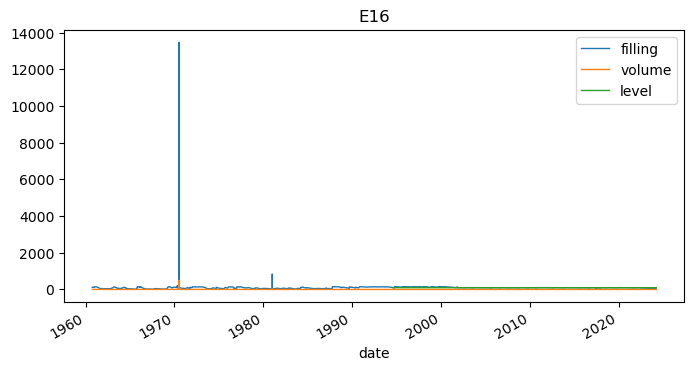

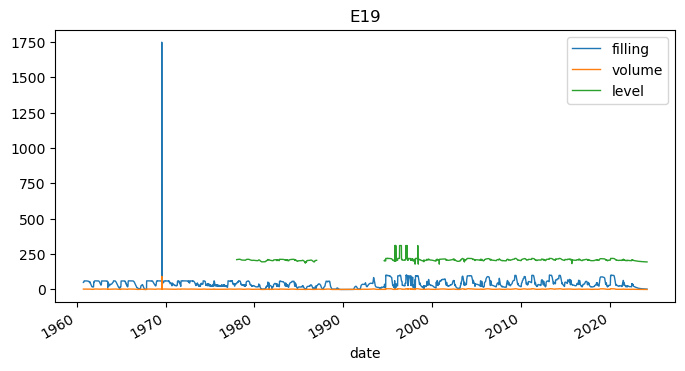

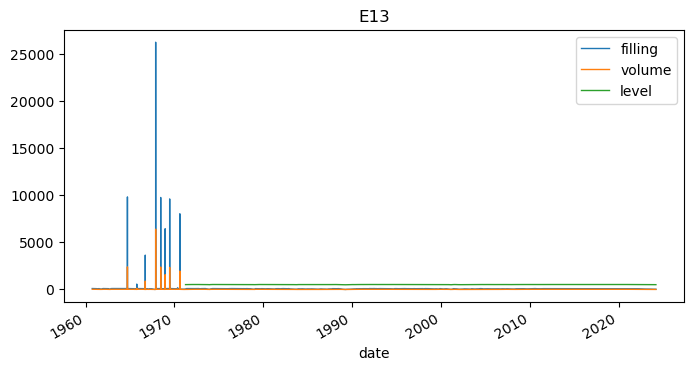

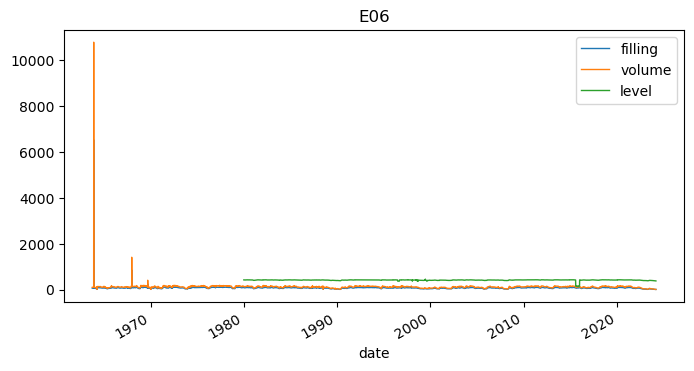

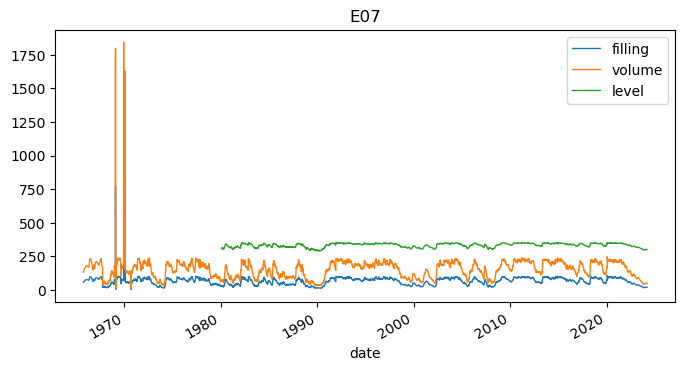

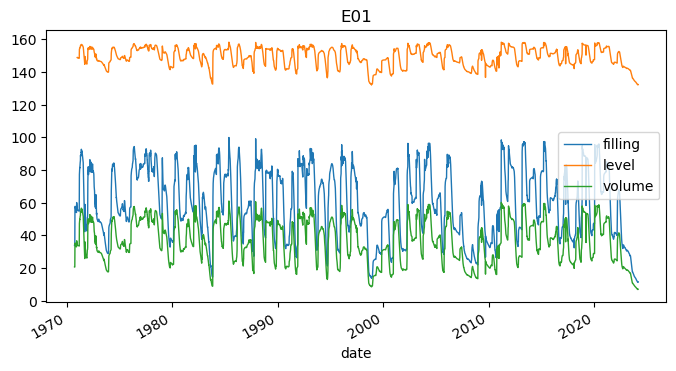

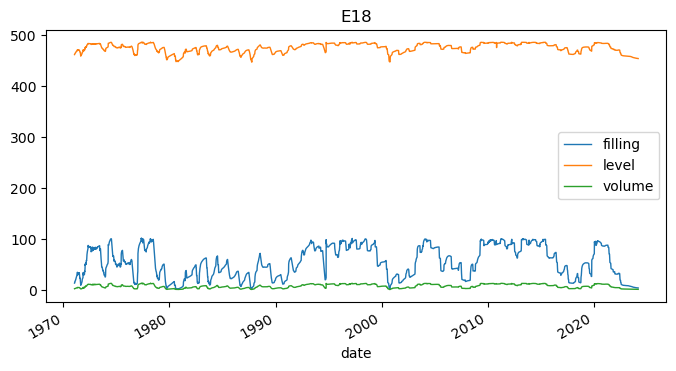

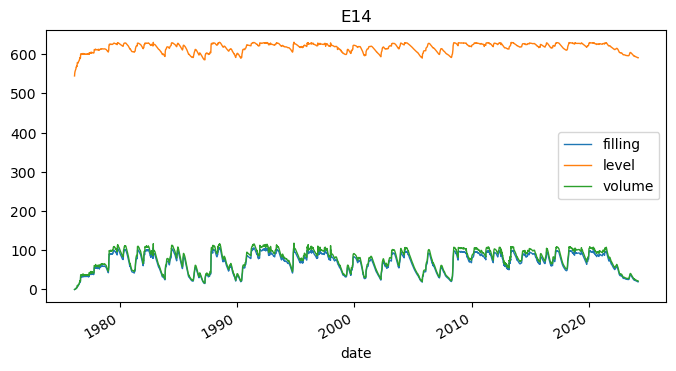

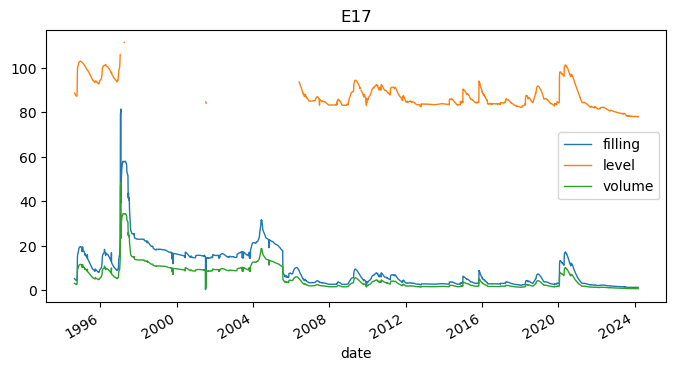

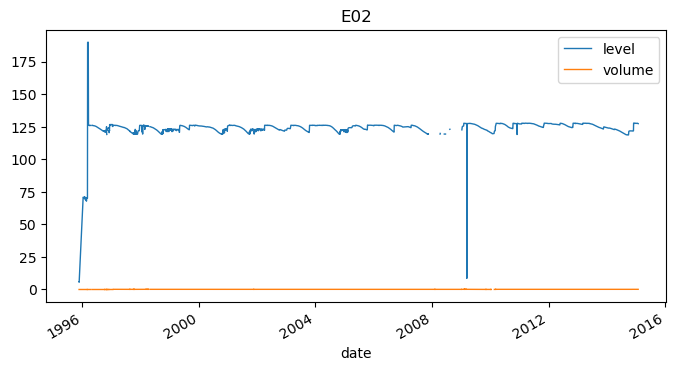

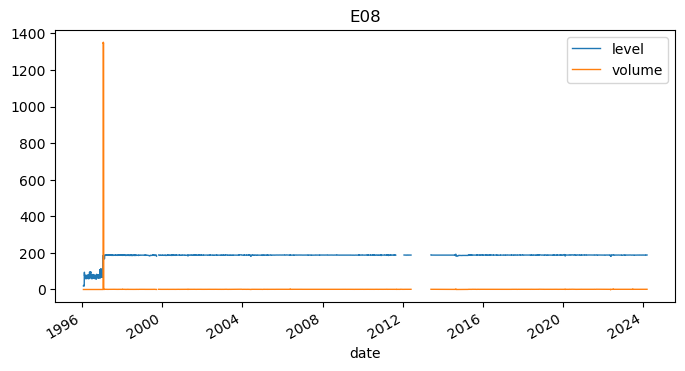

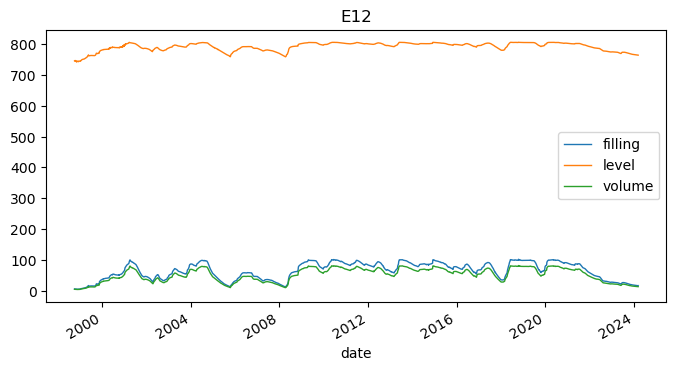

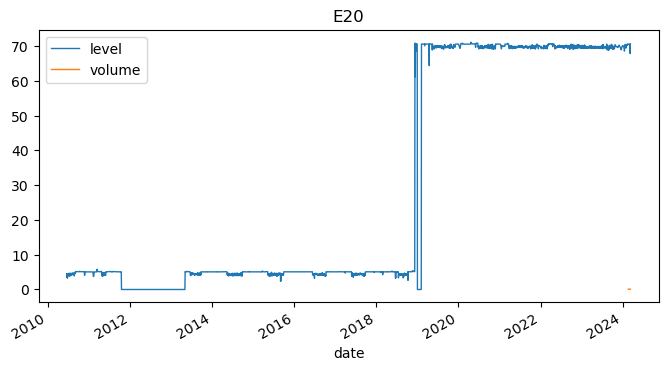

In [17]:
for ID, df in timeseries.items():
    df.to_csv(path_ts / f'{ID}.csv')
    fig, ax = plt.subplots(figsize=(8, 4))
    df.plot(lw=1, ax=ax)
    ax.set_title(ID)
    plt.savefig(path_plot / f'{ID}.jpg', dpi=300, bbox_inches='tight')